In [1]:
import torch
import torchvision
import torch.utils.data as Data
import torch.optim as optim
import random
import numpy as np

from torch import nn
from matplotlib import pyplot as plt

### 线性回归实现
线性回归(Linear Regression)是机器学习和统计学中最基础和广泛应用的模型，是一种对自变量和因变量之间关系进行建模的回归分析。
从机器学习的角度来看，自变量就是样本的特征向量 $x \in R$ (每一维对应一个自变量)，因变量是标签 $y$，这里 $x \in R$ 是连续值。假设空间是一组参数化的线性函数
$$
f(x;𝑤,𝑏) = 𝑥w^T+𝑏
$$
其中，权重向量 $𝒘$ 和偏置 $𝒃$ 是线性回归需要学习的参数， 函数 $f(x;𝑤,𝑏)$ 称为线性模型。

#### 手动实现线性回归
##### 生成数据
设训练数据集样本数为1000，输入个数(特征数)为2，给定随机生成的批量样本特征 $X \in R^{1000 \times 2}$。 <br>
线性回归模型的真实权重 $ w = [2 , −3.4]^T $ 和偏差 $𝑏 = 4.2$, 以及一个随机噪声项 $\epsilon$ 来生成标签。
$$𝑦 = 𝑥𝑤^T + 𝑏 + \epsilon$$
其中，噪声项 $\epsilon$ 服从均值0、标准差为0.01的`正态分布`。噪声代表了数据中无意义的干扰。

In [2]:
num_inputs = 2 
num_examples = 1000 
true_w = [2, -3.4] 
true_b = 4.2
features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float) 
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)
features, labels

(tensor([[ 0.7951, -0.4721],
         [ 0.4241, -0.1669],
         [ 0.0801,  0.7826],
         ...,
         [ 2.7256,  0.2159],
         [ 2.2605, -0.3228],
         [-0.4128,  0.4221]]),
 tensor([ 7.3959e+00,  5.6073e+00,  1.6924e+00,  3.4739e+00,  1.0654e+00,
          4.5220e+00,  4.1421e+00,  9.8292e+00,  5.0117e+00,  5.6048e+00,
          1.9620e+00,  6.0398e+00, -3.7034e+00,  1.5667e+00,  5.4652e+00,
          1.1373e+00,  7.7659e+00,  8.4604e+00,  3.3348e+00,  9.1011e+00,
          5.6248e+00,  3.4115e+00,  6.5809e+00,  2.4064e+00, -8.5358e-01,
          1.2493e+00,  2.7074e+00,  4.4445e+00,  9.6267e+00,  1.5189e+01,
          7.3295e+00,  5.1481e+00,  4.0859e+00,  1.4094e+00,  4.3402e+00,
          4.0373e+00,  3.0124e+00,  5.6115e+00, -3.1837e+00, -1.0741e+00,
          2.5680e+00, -5.8867e+00,  4.1949e+00,  9.1337e+00,  9.8848e+00,
         -6.8707e-01,  8.1947e+00,  3.9214e-01,  1.1323e+00,  6.0221e+00,
          1.8696e+00,  9.8574e+00,  6.8252e+00,  4.3746e+00,  4.0301e+

使用 `𝐮𝐬𝐞_𝐬𝐯𝐠_𝐩𝐚𝐥𝐲()` 和 `𝐬𝐞𝐭_𝐟𝐢𝐠𝐬𝐢𝐳𝐞()` 两个函数来可视化所生成的数据。

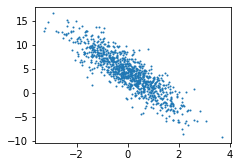

In [3]:
# 设置图的尺寸
def set_figsize(figsize=(3.5, 2.5)):
    plt.rcParams['figure.figsize'] = figsize 
    
set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

##### 读取数据
在模型训练的时候，需要遍历数据集并不断读取小批量的数据样本。这里本实验定义一个函数 `𝐝𝐚𝐭𝐚_𝐢𝐭𝐞𝐫()` 它每次返回 𝒃𝒂𝒕𝒄𝒉_𝒔𝒊𝒛𝒆 (批量大小)个随机样本的特征和标签。

In [4]:
num_inputs = 2
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples)) 
    
    # 样本的读取顺序是随机的 
    random.shuffle(indices) 
    
    # 最后一次可能不足一个batch
    for i in range(0, num_examples, batch_size):
        j = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        
        # 按行选取
        yield features.index_select(dim=0, index=j), labels.index_select(0, j)

##### 构建模型
在构建模型之前，需要将权重和偏置初始化。本实验将权重初始化成均值为0、标准差为 0.01的正态随机数，偏置初始化为0。

In [5]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32) 
b = torch.zeros(1, dtype=torch.float32)
w, b

(tensor([[-0.0122],
         [ 0.0004]]),
 tensor([0.]))

在后面的模型训练中，需要对这些参数求梯度来迭代参数的值，因此要设置requires_grad = True

In [6]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

使用 𝐦𝐦() 函数做矩阵乘法，来实现线性回归的模型。

In [7]:
def linreg(X, w, b):
    return torch.mm(X, w) + b

##### 损失函数和优化算法
本实验使用`平方损失`来定义线性回归的损失函数。在实现中，我们需要把真实值 𝑦 变形成预测值 𝑦_h𝑎𝑡 形状。

In [8]:
def squared_loss(y_hat, y):
    return (y_hat.view(y.size()) - y) ** 2 / 2

以下的 sgd 函数实现了小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。这里自动求梯度模块计算得来提速是一个批量样本的梯度和。我们将它除以批量大小来得到平均值。

In [9]:
def sgd(params, lr, batch_size): 
    for param in params:
        # 注意这里更改param时用的param.data
        param.data -= lr * param.grad / batch_size

##### 模型训练
在训练过程中，模型将会多次迭代更新参数。在每次迭代中，根据当前读取的小批量数据样本(特征 x 和标签 y)，通过调用反向函数backward 计算小批量随机梯度，并调用优化算法 𝐬𝐠𝐝 迭代模型参数 。

In [10]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
batch_size = 32

# 训练模型一共需要num_epochs个迭代周期
for epoch in range(num_epochs): 
    
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次, x和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        
        # 这是一个二维向量
        y_hat = net(X, w, b) 
        
        # l是有关小批量X和y的损失
        l = loss(y_hat, y).sum()  
        
        # 小批量的损失对模型参数求梯度
        l.backward() 
        
        # 使用小批量随机梯度下降迭代模型参数 
        sgd([w, b], lr, batch_size) 
        
        # 梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
        
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 2.361809
epoch 2, loss 0.323957
epoch 3, loss 0.044822


In [11]:
true_w, w

([2, -3.4],
 tensor([[ 1.9281],
         [-3.2420]], requires_grad=True))

In [12]:
true_b, b

(4.2, tensor([3.9622], requires_grad=True))

#### 利用torch.nn实现线性回归
Torch.nn 模块<br>
+ Pytorch为神经网络设计的模块化接口，该模块定义了大量的神经网络层。<br>
+ 𝐧𝐧 利用 `𝐚𝐮𝐭𝐨𝐠𝐫𝐚𝐝` 来定义模型，其核心数据结构是 `𝐌𝐨𝐝𝐮𝐥𝐞`。<br>

下表给出了部分 𝐧𝐧 中所包含模块(其它模块可查阅官方API):

|模块|作用|
|:---:|:----:|
|torch.nn.Module()|Module是所有神经网络模块的基类|
|torch.nn.Linear()|Linear用于对输入数据进行线性变换|
|torch.nn.Sequential()|Sequential是一个顺序容器, 其中模块的添加顺序与在构造函数中传递模块时的顺序相同|
|torch.nn.MSELoss|MSELoss用于衡量输入 x 和目标 y 中每个元素之间的均方误差的标准。|

##### 读取数据
PyTorch提供了 𝐝𝐚𝐭𝐚 库来读取数据。由于data常用作变量名，这里将导入的 𝐝𝐚𝐭𝐚 模块用 𝐃𝐚𝐭𝐚 代替。 对前面的读取数据部分可以使用 𝐝𝐚𝐭𝐚 库来处理。在每一次迭代中，使用 𝐃𝐚𝐭𝐚 随机读取包含10个数据 样本的小批量。

In [13]:
lr = 0.03
batch_size = 10

# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(features, labels)

# 把 dataset 放入 DataLoader
data_iter = Data.DataLoader(
    dataset=dataset,         # torch TensorDataset format
    batch_size=batch_size,   # mini batch size
    shuffle=True,            # 是否打乱数据 (训练集一般需要进行打乱) 
    num_workers=2,           # 多线程来读数据，注意在Windows下需要设置为0
)

##### 构建模型
构建模型的过程中，最常见的方法就是继承 𝐧𝐧. 𝐌𝐨𝐝𝐮𝐥𝐞, 然后构建自己的网络。<br>
一个 𝐧𝐧.𝐌𝐨𝐝𝐮𝐥𝐞 实例需要包含一些层以及返回输出的前向传播方法。

In [14]:
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__() 
        self.linear = nn.Linear(n_feature, 1)
        
    # forward 定义前向传播
    def forward(self, x): 
        y = self.linear(x) 
        return y
    
net = LinearNet(num_inputs)
net

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)

除了继承 𝐧𝐧.𝐌𝐨𝐮𝐝𝐥𝐞 来构建线性回归模型，还可以利用 𝐧𝐧.𝐒𝐞𝐪𝐮𝐞𝐧𝐭𝐢𝐚𝐥 结合 𝐧𝐧.𝐋𝐢𝐧𝐞𝐚𝐫 来搭建模型

In [15]:
#写法一
net = nn.Sequential( 
    nn.Linear(num_inputs, 1) # 此处可以添加其它层
)

# 写法二
# net = nn.Sequential()
# net.add_module('linear', nn.Linear(num_inputs, 1)) 
# net.add_module.........

# 写法三
# from collections import OrderedDict
# net = nn.Sequential(OrderedDict([
# ('linear', nn.Linear(num_inputs, 1)) 
# ......]))

##### 模型参数初始化
在使用定义的模型 net 之前，需要对模型中的一些参数进行初始化。PyTorch 在 init 模块 中提供了许多初始化参数的方法。我们可以调用𝐢𝐧𝐢𝐭.𝐧𝐨𝐫𝐦𝐚𝐥模块通过正态分布对线性回归中的权重和偏差进行初始化

In [16]:
nn.init.normal_(net[0].weight, mean=0, std=0.01)

# 也可以直接修改bias的data:net[0].bias.data.fill_(0)
nn.init.constant_(net[0].bias, val=0) 

Parameter containing:
tensor([0.], requires_grad=True)

##### 损失函数和优化
Pytorch 在 𝑡𝑜𝑟𝑐h.𝑛𝑛 中提供了各种损失函数，这些损失函数实现为 𝐧𝐧.𝐌𝐨𝐝𝐮𝐥𝐞 的子类，可以将这些损失函数作为一种特殊的层。

In [17]:
loss = nn.MSELoss()
loss

MSELoss()

Pytorch在 𝐭𝐨𝐫𝐜𝐡.𝐨𝐩𝐭𝐢𝐦 模块中提供了诸如 𝑺𝑮𝑫、𝑨𝒅𝒂𝒎 和 𝑹𝑴𝑺𝑷𝒓𝒐𝒐𝒑 等优化算法。

In [18]:
# 梯度下降的学习率指定为0.03
optimizer = optim.SGD(net.parameters(), lr=0.03)

# 可以为不同的子网络设置不同学习率
# optimizer =optim.SGD([
#     # 如果不指定学习率，则用默认的最外层学习率 
#     {'params': net.subnet1.parameters()}，
#     {'params': net.subnet2.parameters(), 'lr': 0.01}
# ], lr=0.03)

##### 模型训练
训练模型时，可以调用 𝐨𝐩𝐭𝐢𝐦 中的 𝐬𝐭𝐞𝐩() 函数来迭代模型参数。<br>
按照小批量随机梯度下降的定义，在 𝐬𝐭𝐞𝐩() 函数中指定批量大小，从而对批量中的样本梯度求平均。

In [19]:
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter: 
        output = net(X)
        l = loss(output, y.view(-1, 1))

        # 梯度清零，等价于net.zero_grad() 
        optimizer.zero_grad() 

        l.backward()

        optimizer.step()

    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 0.000231
epoch 2, loss: 0.000053
epoch 3, loss: 0.000096


##### 模型预测及评价
对于分类问题，给定任一样本特征，模型可以预测每个输出类别的概率。<br>
通常，我们把`预测概率最大`的类别作为输出类别。<br>
如果它与真实类别(标签)一致，说明这次预测是正确的。我们使用准确率(accuracy)来评价模型的表现。<br>
它等于正确预测数量与总预测数量之比。

In [20]:
def accuracy(y_hat: torch.Tensor, y: torch.Tensor):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

In [21]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [22]:
evaluate_accuracy(data_iter, net)

0.0